In [1]:
import os
import sys
import torch
import yaml
from typing import Dict, Any

sys.path.append(os.getcwd())

from utils.functions import load_model_class

# ============================================================================
# Configuration
# ============================================================================

CHECKPOINT_PATH = "/home/zakarianarjis/workspace/TinyRecursiveModels/checkpoints/Sudoku-extreme-1k-aug-1000-ACT-torch/pretrain_mlp_t_sudoku_2z/step_65100"
CHECKPOINT_PATH = "/home/zakarianarjis/workspace/TinyRecursiveModels/checkpoints/Sudoku-extreme-1k-aug-1000-ACT-torch/pretrain_mlp_t_sudoku_zeros_init_768/step_65100"

# CHECKPOINT_PATH = "/home/zakarianarjis/workspace/TinyRecursiveModels/checkpoints/single_z/step_65100"
DATA_PATH = "data/sudoku-extreme-1k-aug-1000"  # Need this to get dataset metadata

# ============================================================================
# Helper Functions
# ============================================================================

def strip_compiled_prefix(state_dict):
    """Remove _orig_mod. prefix from compiled model state dict."""
    new_state_dict = {}
    for key, value in state_dict.items():
        if key.startswith('_orig_mod.'):
            new_key = key.replace('_orig_mod.', '')
            new_state_dict[new_key] = value
        else:
            new_state_dict[key] = value
    return new_state_dict

def get_dataset_metadata(data_path, split="test"):
    """Load dataset metadata without loading the full dataset."""
    import json
    from dataset.common import PuzzleDatasetMetadata
    
    metadata_file = os.path.join(data_path, split, "dataset.json")
    with open(metadata_file, "r") as f:
        metadata = PuzzleDatasetMetadata(**json.load(f))
    
    return metadata

def load_model(checkpoint_path, data_path=None, device="cuda"):
    """Load model from checkpoint."""
    
    # Load config
    config_file = os.path.join(os.path.dirname(checkpoint_path), "all_config.yaml")
    with open(config_file, "r") as f:
        full_config = yaml.safe_load(f)
    
    # Extract model config
    arch_config = full_config["arch"]
    model_name = arch_config["name"]
    loss_config = arch_config["loss"]
    loss_name = loss_config["name"]
    
    # Build model config
    model_cfg = {k: v for k, v in arch_config.items() if k not in ["name", "loss"]}
    model_cfg["causal"] = False
    
    # Get dataset metadata if data_path provided, otherwise use defaults from config
    if data_path is not None:
        metadata = get_dataset_metadata(data_path)
        model_cfg["vocab_size"] = metadata.vocab_size
        model_cfg["seq_len"] = metadata.seq_len
        model_cfg["num_puzzle_identifiers"] = metadata.num_puzzle_identifiers
        model_cfg["batch_size"] = full_config.get("global_batch_size", 64)
    else:
        # Try to infer from training config
        train_data_path = full_config["data_paths"][0]
        if os.path.exists(train_data_path):
            metadata = get_dataset_metadata(train_data_path, split="train")
            model_cfg["vocab_size"] = metadata.vocab_size
            model_cfg["seq_len"] = metadata.seq_len
            model_cfg["num_puzzle_identifiers"] = metadata.num_puzzle_identifiers
            model_cfg["batch_size"] = full_config.get("global_batch_size", 64)
        else:
            raise ValueError(f"Cannot find dataset at {train_data_path}. Please provide data_path argument.")
    
    # Load classes
    model_cls = load_model_class(model_name)
    loss_head_cls = load_model_class(loss_name)
    loss_kwargs = {k: v for k, v in loss_config.items() if k != "name"}
    
    # Create model
    with torch.device(device):
        model = model_cls(model_cfg)
        model = loss_head_cls(model, **loss_kwargs)
        
        # Load weights
        state_dict = torch.load(checkpoint_path, map_location=device)
        state_dict = strip_compiled_prefix(state_dict)
        model.load_state_dict(state_dict, strict=True)
        model.eval()
    
    return model, full_config, model_cfg

def inspect_model_structure(model):
    """Print detailed model structure."""
    print("\n" + "=" * 80)
    print("DETAILED MODEL STRUCTURE")
    print("=" * 80)
    
    print("\nLayer breakdown:")
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:  # Only leaf modules
            num_params = sum(p.numel() for p in module.parameters())
            if num_params > 0:
                print(f"  {name}: {module.__class__.__name__} ({num_params:,} params)")

def inspect_state_dict(model):
    """Print state dict keys and shapes."""
    print("\n" + "=" * 80)
    print("MODEL STATE DICT")
    print("=" * 80)
    
    for name, param in model.state_dict().items():
        print(f"  {name}: {tuple(param.shape)}")

# ============================================================================
# Load Model
# ============================================================================

model, full_config, model_cfg = load_model(CHECKPOINT_PATH, DATA_PATH)

print("=" * 80)
print("MODEL LOADED SUCCESSFULLY")
print("=" * 80)

# Print config
print("\nModel Configuration:")
for key, value in model_cfg.items():
    print(f"  {key}: {value}")

print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Print model structure
print("\n" + "=" * 80)
print("MODEL STRUCTURE (HIGH LEVEL)")
print("=" * 80)
print(model)

# ============================================================================
# Input/Output Shapes
# ============================================================================

print("\n" + "=" * 80)
print("INPUT/OUTPUT TENSOR SHAPES")
print("=" * 80)

batch_size = 1
seq_len = model_cfg["seq_len"]
vocab_size = model_cfg["vocab_size"]
num_puzzle_identifiers = model_cfg["num_puzzle_identifiers"]

print(f"\nBatch structure:")
print(f"  inputs: torch.Tensor of shape ({batch_size}, {seq_len})")
print(f"    - dtype: torch.int32 or torch.long")
print(f"    - values: token IDs in range [0, {vocab_size - 1}]")
print(f"\n  labels: torch.Tensor of shape ({batch_size}, {seq_len})")
print(f"    - dtype: torch.int32 or torch.long")
print(f"    - values: token IDs in range [0, {vocab_size - 1}] or -100 (ignore)")
print(f"\n  puzzle_identifiers: torch.Tensor of shape ({batch_size},)")
print(f"    - dtype: torch.int32 or torch.long")
print(f"    - values: puzzle IDs in range [0, {num_puzzle_identifiers - 1}]")

print(f"\nOutput structure:")
print(f"  logits: torch.Tensor of shape ({batch_size}, {seq_len}, {vocab_size})")
print(f"    - unnormalized logits for each token position")



MODEL LOADED SUCCESSFULLY

Model Configuration:
  H_cycles: 3
  H_layers: 0
  L_cycles: 6
  L_layers: 2
  expansion: 4
  forward_dtype: bfloat16
  halt_exploration_prob: 0.1
  halt_max_steps: 16
  hidden_size: 512
  latent_init_random: False
  mlp_t: True
  no_ACT_continue: True
  num_heads: 8
  pos_encodings: none
  puzzle_emb_len: 16
  puzzle_emb_ndim: 512
  random_z_H: False
  causal: False
  vocab_size: 11
  seq_len: 81
  num_puzzle_identifiers: 1
  batch_size: 768

Total parameters: 5,028,866
Trainable parameters: 5,028,866

MODEL STRUCTURE (HIGH LEVEL)
ACTLossHead(
  (model): TinyRecursiveReasoningModel_ACTV1(
    (inner): TinyRecursiveReasoningModel_ACTV1_Inner(
      (embed_tokens): CastedEmbedding()
      (lm_head): CastedLinear()
      (q_head): CastedLinear()
      (puzzle_emb): CastedSparseEmbedding()
      (L_level): TinyRecursiveReasoningModel_ACTV1ReasoningModule(
        (layers): ModuleList(
          (0-1): 2 x TinyRecursiveReasoningModel_ACTV1Block(
            (mlp_

In [2]:
# import torch
# from puzzle_dataset import PuzzleDataset, PuzzleDatasetConfig
# from torch.utils.data import DataLoader
# import torch

# def get_sudoku_embedding(model: torch.nn.Module,
#                          dataset_path: str = "/home/zakarianarjis/workspace/TinyRecursiveModels/data/sudoku-extreme-1k-aug-1000"):
#     """
#     Loads one sample from the Sudoku dataset and returns the combined input embedding
#     (token embeddings + puzzle embeddings) suitable for the ACT model.
#     """
#     # Minimal config compatible with PuzzleDataset
#     dataset_config = PuzzleDatasetConfig(
#         seed=42,
#         dataset_paths=[dataset_path],
#         rank=0,
#         num_replicas=1,
#         epochs_per_iter=1,
#         batch_size=1,
#         test_set_mode=False,
#         global_batch_size=1
#     )

#     # Load dataset and dataloader
#     dataset = PuzzleDataset(dataset_config, split="train")
#     dataloader = DataLoader(dataset, batch_size=None)  # batch_size=None for iterable datasets

#     # Take the first sample
#     batch = next(iter(dataloader))
#     sample_dict = batch[1]  # the dict with 'inputs', 'labels', 'puzzle_identifiers'

#     token_ids = sample_dict['inputs'].cuda()                 # [seq_len]
#     puzzle_ids = sample_dict['puzzle_identifiers'].cuda()    # [num_puzzle_identifiers]

#     # Ensure batch dimension
#     token_ids = token_ids  # [1, seq_len]
#     puzzle_ids = puzzle_ids.unsqueeze(0) # [1, num_puzzle_identifiers]
#     print(token_ids.shape, puzzle_ids.shape)
#     # --- Construct combined embedding ---
#     # This uses the _input_embeddings method which handles puzzle embeddings internally
#     full_input_embed = model.model.inner._input_embeddings(
#         token_ids, puzzle_identifiers=puzzle_ids
#     )  # [1, seq_len + puzzle_emb_len, hidden_size]

#     return full_input_embed.squeeze(0), token_ids.squeeze(0)  # [seq_len + puzzle_emb_len, hidden_size], [seq_len]

# model.eval()
# embedding, ids = get_sudoku_embedding(model, dataset_path="/home/zakarianarjis/workspace/TinyRecursiveModels/data/sudoku-extreme-1k-aug-1000")
# # Test L_level with dummy input
# import torch

# L_level = model.model.inner.L_level
# hidden_size = model_cfg["hidden_size"]
# seq_len_with_emb = model_cfg["seq_len"] + model.model.inner.puzzle_emb_len
# batch_size_test = 1

# hidden_states = 2 * torch.randn(batch_size_test, seq_len_with_emb, hidden_size, device="cuda", dtype=torch.bfloat16) 
# input_injection = embedding.clone()
# cos_sin = model.model.inner.rotary_emb() if hasattr(model.model.inner, 'rotary_emb') else None

# # with torch.no_grad():
# #     output_1 = L_level(hidden_states=hidden_states ,cos_sin=cos_sin)
# #     output_2 = L_level(hidden_states=output_1 ,cos_sin=cos_sin)
# output = hidden_states.clone() + input_injection
# for i in range(10):
#     previous_output = output.clone()
#     with torch.no_grad():
#         output = L_level(hidden_states=output, cos_sin=cos_sin)  
# print(output-previous_output)

In [63]:
import torch
from puzzle_dataset import PuzzleDataset, PuzzleDatasetConfig
from torch.utils.data import DataLoader
from typing import Dict, List, Tuple
import numpy as np


# def gather_reasoning_sequences(
#     model: torch.nn.Module,
#     dataset_path: str,
#     num_samples: int = 10,
#     split: str = "train"
# ) -> Dict[str, List[torch.Tensor]]:
#     """
#     Run inference on samples and gather z_H and z_L sequences.
    
#     Args:
#         model: The loaded TinyRecursiveReasoningModel_ACTV1 model
#         dataset_path: Path to the puzzle dataset
#         num_samples: Number of samples to process
#         split: Dataset split ("train" or "test")
    
#     Returns:
#         Dictionary containing:
#             - 'z_H_sequences': List of z_H sequences, each of shape [H_cycles, seq_len+puzzle_emb_len, hidden_size]
#             - 'z_L_sequences': List of z_L sequences, each of shape [H_cycles*L_cycles, seq_len+puzzle_emb_len, hidden_size]
#             - 'inputs': List of input token IDs
#             - 'labels': List of label token IDs
#             - 'puzzle_ids': List of puzzle identifiers
#     """
#     model.eval()
    
#     # Setup dataset
#     dataset_config = PuzzleDatasetConfig(
#         seed=42,
#         dataset_paths=[dataset_path],
#         rank=0,
#         num_replicas=1,
#         epochs_per_iter=1,
#         batch_size=1,
#         test_set_mode=(split == "test"),
#         global_batch_size=1
#     )
    
#     dataset = PuzzleDataset(dataset_config, split=split)
#     dataloader = DataLoader(dataset, batch_size=None)
    
#     # Storage for results
#     results = {
#         'z_H_sequences': [],
#         'z_L_sequences': [],
#         'inputs': [],
#         'labels': [],
#         'puzzle_ids': [],
#         'num_steps': []  # Track how many ACT steps were taken
#     }
    
#     with torch.inference_mode():
#         samples_processed = 0
        
#         for batch_data in dataloader:
#             if samples_processed >= num_samples:
#                 break
                
#             set_name, sample_dict, global_batch_size = batch_data
            
#             # Move to GPU
#             batch = {k: v.cuda() for k, v in sample_dict.items()}
            
#             # Initialize carry
#             with torch.device("cuda"):
#                 carry = model.initial_carry(batch)
#             # Run inference with ACT loop
#             step_count = 0
#             sample_z_H_seq = []
#             sample_z_L_seq = []
            
#             while True:
#                 carry, outputs = model(carry=carry, batch=batch, return_sequences=True)
#                 step_count += 1
                
#                 # Gather sequences from this ACT step
#                 if 'z_H_sequence' in outputs and outputs['z_H_sequence'] is not None:
#                     sample_z_H_seq.extend(outputs['z_H_sequence'])
#                 if 'z_L_sequence' in outputs and outputs['z_L_sequence'] is not None:
#                     sample_z_L_seq.extend(outputs['z_L_sequence'])
                
#                 # Check if all sequences in batch have halted
#                 if carry.halted.all():
#                     break
            
#             # Stack sequences for this sample
#             # z_H_seq: each element is [1, seq_len+puzzle_emb_len, hidden_size]
#             # Stack along new dimension to get [num_H_updates, seq_len+puzzle_emb_len, hidden_size]
#             if sample_z_H_seq:
#                 z_H_stacked = torch.stack(sample_z_H_seq, dim=0).squeeze(1)  # Remove batch dim
#                 results['z_H_sequences'].append(z_H_stacked.cpu())
            
#             if sample_z_L_seq:
#                 z_L_stacked = torch.stack(sample_z_L_seq, dim=0).squeeze(1)
#                 results['z_L_sequences'].append(z_L_stacked.cpu())
            
#             # Store other data
#             results['inputs'].append(batch['inputs'].cpu())
#             results['labels'].append(batch['labels'].cpu())
#             results['puzzle_ids'].append(batch['puzzle_identifiers'].cpu())
#             results['num_steps'].append(step_count)
            
#             samples_processed += 1
#             print(f"Processed sample {samples_processed}/{num_samples}, ACT steps: {step_count}, "
#                   f"z_H updates: {len(sample_z_H_seq)}, z_L updates: {len(sample_z_L_seq)}")
    
#     print(f"\nGathered sequences from {samples_processed} samples")
#     print(f"Average ACT steps: {np.mean(results['num_steps']):.2f}")
    
#     return results

def gather_reasoning_sequences(
    model: torch.nn.Module,
    dataset_path: str,
    num_samples: int = 10,
    split: str = "train"
) -> Dict[str, List[torch.Tensor]]:
    """
    Run inference on samples and gather z_H and z_L sequences.
    
    Args:
        model: The loaded TinyRecursiveReasoningModel_ACTV1 model
        dataset_path: Path to the puzzle dataset
        num_samples: Number of samples to process
        split: Dataset split ("train" or "test")
    
    Returns:
        Dictionary containing:
            - 'z_H_sequences': List of z_H sequences, each of shape [num_H_updates, seq_len+puzzle_emb_len, hidden_size]
            - 'z_L_sequences': List of z_L sequences, each of shape [num_L_updates, seq_len+puzzle_emb_len, hidden_size]
            - 'inputs': List of input token IDs
            - 'labels': List of label token IDs
            - 'puzzle_ids': List of puzzle identifiers
            - 'num_steps': List of total ACT steps per sample
            - 'accuracy_per_step': List of accuracy trajectories, each is a list of accuracies at each step
            - 'final_accuracy': List of final accuracy for each sample
    """
    model.eval()
    
    # Setup dataset
    dataset_config = PuzzleDatasetConfig(
        seed=42,
        dataset_paths=[dataset_path],
        rank=0,
        num_replicas=1,
        epochs_per_iter=1,
        batch_size=1,
        test_set_mode=(split == "test"),
        global_batch_size=1
    )
    
    dataset = PuzzleDataset(dataset_config, split=split)
    dataloader = DataLoader(dataset, batch_size=None)
    
    # Storage for results
    results = {
        'z_H_sequences': [],
        'z_L_sequences': [],
        'inputs': [],
        'labels': [],
        'puzzle_ids': [],
        'num_steps': [],
        'accuracy_per_step': [],  # Track accuracy at each ACT step
        'final_accuracy': []  # Final accuracy for each sample
    }
    
    with torch.inference_mode():
        samples_processed = 0
        
        for batch_data in dataloader:
            if samples_processed >= num_samples:
                break
                
            set_name, sample_dict, global_batch_size = batch_data
            
            # Move to GPU
            batch = {k: v.cuda() for k, v in sample_dict.items()}
            
            # Initialize carry
            with torch.device("cuda"):
                carry = model.initial_carry(batch)
            
            # Run inference with ACT loop
            step_count = 0
            sample_z_H_seq = []
            sample_z_L_seq = []
            sample_accuracies = []  # Accuracy at each step for this sample
            
            # Get labels for accuracy computation
            labels = batch['labels']  # [batch_size, seq_len]
            
            while True:
                carry, outputs = model(carry=carry, batch=batch, return_sequences=True)
                step_count += 1
                
                # Gather sequences from this ACT step
                if 'z_H_sequence' in outputs and outputs['z_H_sequence'] is not None:
                    sample_z_H_seq.extend(outputs['z_H_sequence'])
                if 'z_L_sequence' in outputs and outputs['z_L_sequence'] is not None:
                    sample_z_L_seq.extend(outputs['z_L_sequence'])
                
                # Compute accuracy at this step
                logits = outputs['logits']  # [batch_size, seq_len, vocab_size]
                predictions = torch.argmax(logits, dim=-1)  # [batch_size, seq_len]
                
                # Create mask for valid positions (not IGNORE_LABEL_ID)
                valid_mask = (labels != -100)  # Assuming IGNORE_LABEL_ID = -100
                
                if valid_mask.any():
                    # Compute accuracy only on valid positions
                    correct = (predictions == labels) & valid_mask
                    accuracy = correct.sum().float() / valid_mask.sum().float()
                    sample_accuracies.append(accuracy.item())
                else:
                    # If no valid labels, set accuracy to 0
                    sample_accuracies.append(0.0)
                
                # Check if all sequences in batch have halted
                if carry.halted.all():
                    break
            
            # Stack sequences for this sample
            if sample_z_H_seq:
                z_H_stacked = torch.stack(sample_z_H_seq, dim=0).squeeze(1)  # Remove batch dim
                results['z_H_sequences'].append(z_H_stacked.cpu().to(torch.float16))
            
            if sample_z_L_seq:
                z_L_stacked = torch.stack(sample_z_L_seq, dim=0).squeeze(1)
                results['z_L_sequences'].append(z_L_stacked.cpu().to(torch.float16))
            
            # Store other data
            results['inputs'].append(batch['inputs'].cpu())
            results['labels'].append(batch['labels'].cpu())
            # results['puzzle_ids'].append(batch['puzzle_identifiers'].cpu())
            results['num_steps'].append(step_count)
            results['accuracy_per_step'].append(sample_accuracies)
            results['final_accuracy'].append(sample_accuracies[-1] if sample_accuracies else 0.0)
            
            samples_processed += 1
            print(f"Processed sample {samples_processed}/{num_samples}, ACT steps: {step_count}, "
                  f"z_H updates: {len(sample_z_H_seq)}, z_L updates: {len(sample_z_L_seq)}, "
                  f"Final accuracy: {sample_accuracies[-1]:.4f}")
    
    print(f"\nGathered sequences from {samples_processed} samples")
    print(f"Average ACT steps: {np.mean(results['num_steps']):.2f}")
    print(f"Average final accuracy: {np.mean(results['final_accuracy']):.4f}")
    
    return results

In [64]:
dataset_path = "/home/zakarianarjis/workspace/TinyRecursiveModels/data/sudoku-extreme-1k-aug-1000"
Nsup = 32
num_samples = 50
model.model.config.halt_max_steps = Nsup
model = model.cuda()
model.model = model.model.cuda()
sequences = gather_reasoning_sequences(
    model=model.model,
    dataset_path=dataset_path,
    num_samples=num_samples,
    split="test"
)
zH_list = sequences['z_H_sequences']
zL_list = sequences['z_L_sequences']
accuracy = sequences['accuracy_per_step']
exact_accuracy  = [ list(map( lambda x:int(x==1), acc_list)) for acc_list in accuracy]

Processed sample 1/50, ACT steps: 32, z_H updates: 96, z_L updates: 576, Final accuracy: 1.0000
Processed sample 2/50, ACT steps: 32, z_H updates: 96, z_L updates: 576, Final accuracy: 1.0000
Processed sample 3/50, ACT steps: 32, z_H updates: 96, z_L updates: 576, Final accuracy: 1.0000
Processed sample 4/50, ACT steps: 32, z_H updates: 96, z_L updates: 576, Final accuracy: 1.0000
Processed sample 5/50, ACT steps: 32, z_H updates: 96, z_L updates: 576, Final accuracy: 0.5802
Processed sample 6/50, ACT steps: 32, z_H updates: 96, z_L updates: 576, Final accuracy: 0.4938
Processed sample 7/50, ACT steps: 32, z_H updates: 96, z_L updates: 576, Final accuracy: 1.0000
Processed sample 8/50, ACT steps: 32, z_H updates: 96, z_L updates: 576, Final accuracy: 0.5802
Processed sample 9/50, ACT steps: 32, z_H updates: 96, z_L updates: 576, Final accuracy: 1.0000
Processed sample 10/50, ACT steps: 32, z_H updates: 96, z_L updates: 576, Final accuracy: 1.0000
Processed sample 11/50, ACT steps: 32, 

(95,)


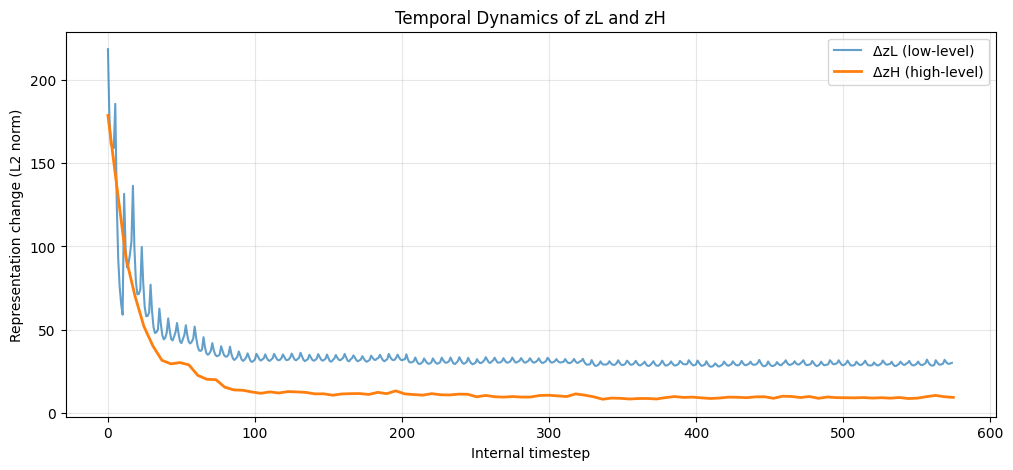

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_temporal_dynamics(zL_list, zH_list, accuracy_list, L_cycles=6, H_cycles=3, N_sup=16):
    """
    zL_list: list of tensors, each (288,97,512)
    zH_list: list of tensors, each (48,97,512)
    accuracy_list: list of lists, each with 16 elements
    """

    # Combine samples into one tensor and convert to float32
    zL = torch.stack([z.float() for z in zL_list])     # shape (N_samples, 288, 97, 512)
    zH = torch.stack([z.float() for z in zH_list])     # shape (N_samples, 48, 97, 512)

    # --- Compute ΔzL and ΔzH ---
    # Δz = L2 norm across feature dims (97,512)
    d_zL = torch.norm(zL[:, 1:] - zL[:, :-1], dim=(2, 3))  # (N_samples, 287)
    d_zH = torch.norm(zH[:, 1:] - zH[:, :-1], dim=(2, 3))  # (N_samples, 47)

    # Average over samples
    d_zL_mean = d_zL.mean(dim=0).cpu().numpy()
    d_zH_mean = d_zH.mean(dim=0).cpu().numpy()
    print( d_zH_mean.shape)
    # -------------- PLOT 1: Full Temporal Dynamics ----------------
    plt.figure(figsize=(12,5))
    plt.plot(d_zL_mean, label="ΔzL (low-level)", alpha=0.7)
    plt.plot(np.linspace(0, len(d_zL_mean), len(d_zH_mean)),
             d_zH_mean, label="ΔzH (high-level)", linewidth=2)
    plt.xlabel("Internal timestep")
    plt.ylabel("Representation change (L2 norm)")
    plt.title("Temporal Dynamics of zL and zH")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_temporal_dynamics(zL_list, zH_list, accuracy, L_cycles=6, H_cycles=3, N_sup=Nsup)

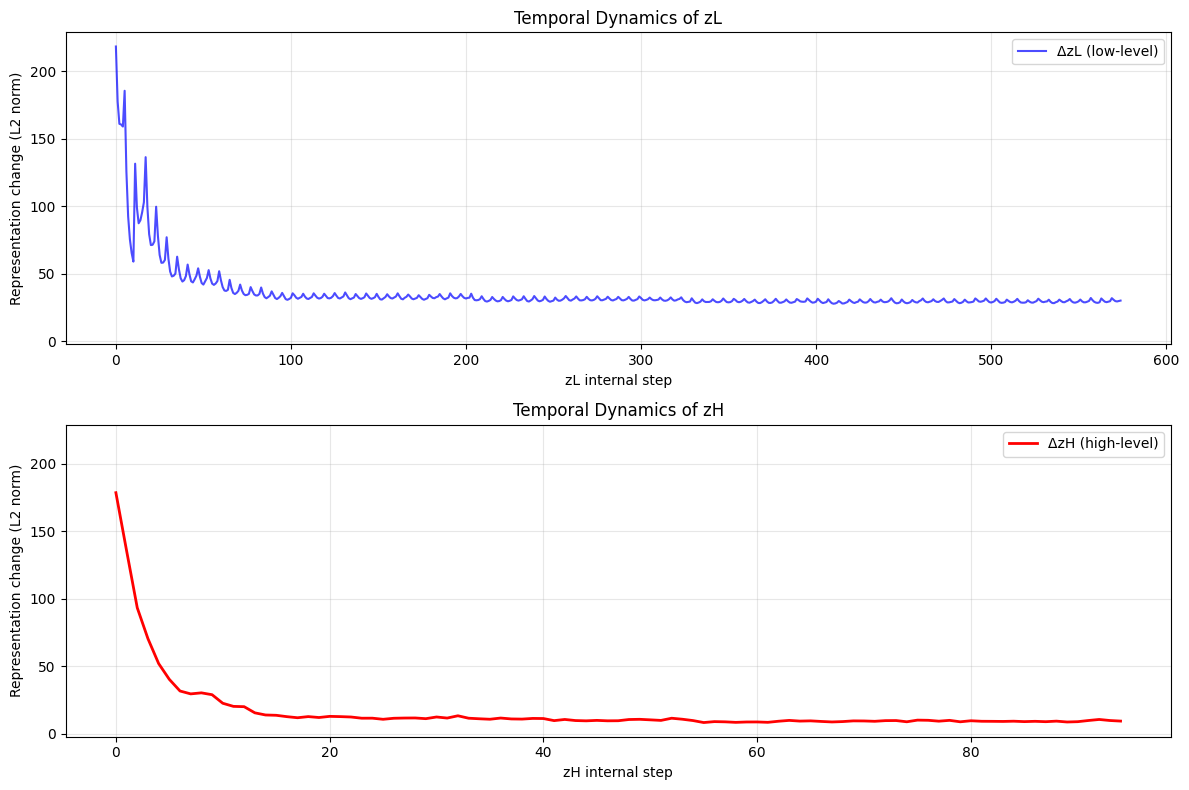

In [84]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def plot_temporal_dynamics(zL_list, zH_list, accuracy_list=None, 
                           L_cycles=6, H_cycles=3, N_sup=16, overlay=True):
    """
    Plot temporal dynamics of zL and zH in two separate aligned plots.
    
    Args:
        zL_list: list of tensors, each (288, 97, 512)
        zH_list: list of tensors, each (48, 97, 512)
        accuracy_list: optional, list of lists of length N_sup
        overlay: if True, show stretched zH curve in zL plot for qualitative comparison
    """
    # Combine samples and convert to float32
    zL = torch.stack([z.float() for z in zL_list])  # (N_samples, 288, 97, 512)
    zH = torch.stack([z.float() for z in zH_list])  # (N_samples, 48, 97, 512)

    # Compute ΔzL and ΔzH (L2 norm across feature dims)
    d_zL = torch.norm(zL[:, 1:] - zL[:, :-1], dim=(2, 3))  # (N_samples, 287)
    d_zH = torch.norm(zH[:, 1:] - zH[:, :-1], dim=(2, 3))  # (N_samples, 47)

    # Average over samples
    d_zL_mean = d_zL.mean(dim=0).cpu().numpy()
    d_zH_mean = d_zH.mean(dim=0).cpu().numpy()

    # Optional: interpolate zH to match zL steps for overlay
    if overlay:
        x_H = np.linspace(0, len(d_zL_mean)-1, len(d_zH_mean))
        f = interp1d(x_H, d_zH_mean, kind='linear')
        d_zH_interp = f(np.arange(len(d_zL_mean)))
    
    # --- Plotting ---
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharey=True)

    # 1️⃣ zL plot
    axs[0].plot(d_zL_mean, label='ΔzL (low-level)', color='blue', alpha=0.7)
    if overlay:
        axs[0].plot(d_zH_interp, label='ΔzH (high-level, stretched)', color='red', alpha=0.5, linestyle='--')
    axs[0].set_xlabel('zL internal step')
    axs[0].set_ylabel('Representation change (L2 norm)')
    axs[0].set_title('Temporal Dynamics of zL')
    axs[0].legend()
    axs[0].grid(alpha=0.3)

    # 2️⃣ zH plot
    axs[1].plot(d_zH_mean, label='ΔzH (high-level)', color='red', linewidth=2)
    axs[1].set_xlabel('zH internal step')
    axs[1].set_ylabel('Representation change (L2 norm)')
    axs[1].set_title('Temporal Dynamics of zH')
    axs[1].legend()
    axs[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
plot_temporal_dynamics(zL_list, zH_list,overlay=False)

Pearson correlation ΔzL vs Accuracy: -0.972 (p=0.000)
Pearson correlation ΔzH vs Accuracy: -0.961 (p=0.000)


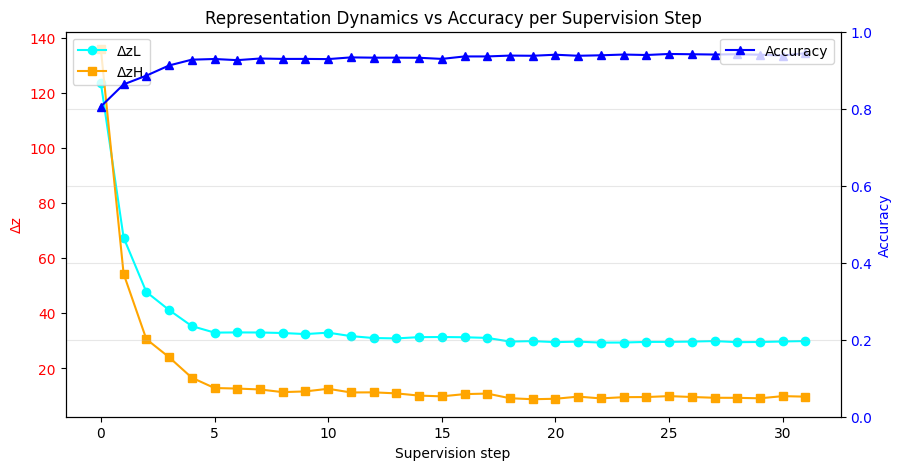

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def correlation_dynamics_accuracy(zL_list, zH_list, accuracy_list, L_cycles=6, H_cycles=3, N_sup=16):
    """
    zL_list: list of tensors, each (288,97,512)
    zH_list: list of tensors, each (48,97,512)
    accuracy_list: list of lists, each with 16 elements
    """

    # Convert to float32 and stack
    zL = torch.stack([z.float() for z in zL_list])
    zH = torch.stack([z.float() for z in zH_list])

    # --- Compute ΔzL and ΔzH ---
    d_zL = torch.norm(zL[:, 1:] - zL[:, :-1], dim=(2, 3))
    d_zH = torch.norm(zH[:, 1:] - zH[:, :-1], dim=(2, 3))

    # Average over samples
    d_zL_mean = d_zL.mean(dim=0).cpu().numpy()
    d_zH_mean = d_zH.mean(dim=0).cpu().numpy()

    # --- Aggregate per supervision step ---
    d_zL_sup = []
    for i in range(N_sup):
        start = i * L_cycles * H_cycles
        end = (i + 1) * L_cycles * H_cycles
        d_zL_sup.append(d_zL_mean[start:end].mean())
    d_zL_sup = np.array(d_zL_sup)

    d_zH_sup = []
    for i in range(N_sup):
        start = i * H_cycles
        end = (i + 1) * H_cycles
        d_zH_sup.append(d_zH_mean[start:end].mean())
    d_zH_sup = np.array(d_zH_sup)

    # --- Prepare accuracy ---
    accuracy = np.mean(np.array(accuracy_list), axis=0)

    # --- Compute correlations ---
    corr_zL, p_zL = pearsonr(d_zL_sup, accuracy)
    corr_zH, p_zH = pearsonr(d_zH_sup, accuracy)

    print(f"Pearson correlation ΔzL vs Accuracy: {corr_zL:.3f} (p={p_zL:.3f})")
    print(f"Pearson correlation ΔzH vs Accuracy: {corr_zH:.3f} (p={p_zH:.3f})")

    # --- Plot with two y-axes ---
    fig, ax1 = plt.subplots(figsize=(10,5))

    ax1.set_xlabel("Supervision step")
    ax1.set_ylabel("Δz", color='red')
    ax1.plot(d_zL_sup, 'o-', color='cyan', label="ΔzL")
    ax1.plot(d_zH_sup, 's-', color='orange', label="ΔzH")
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", color='blue')
    ax2.plot(accuracy, '^-', color='blue', label="Accuracy")
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper right')

    plt.title("Representation Dynamics vs Accuracy per Supervision Step")
    plt.grid(alpha=0.3)
    plt.show()
correlation_dynamics_accuracy(zL_list, zH_list, accuracy, L_cycles=6, H_cycles=3, N_sup=Nsup)

Pearson correlation ΔzL vs Accuracy: -0.901 (p=0.000)
Pearson correlation ΔzH vs Accuracy: -0.896 (p=0.000)


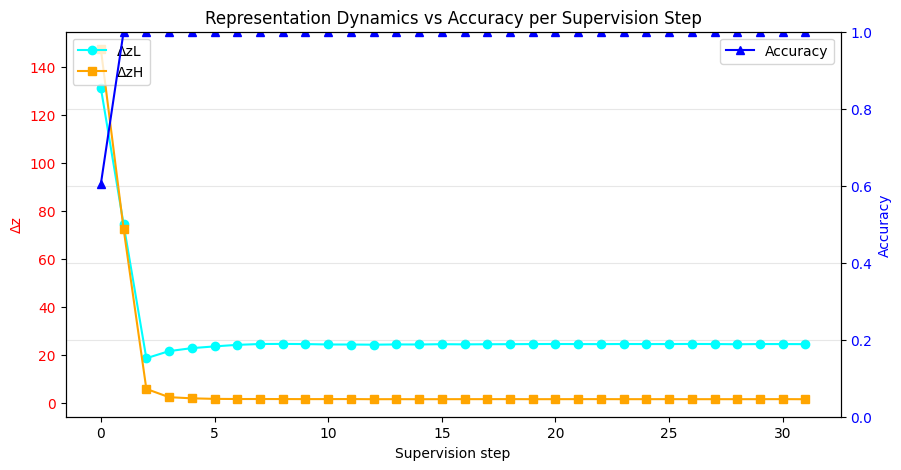

In [96]:
index = 9
correlation_dynamics_accuracy([zL_list[index]], [zH_list[index]], [accuracy[index]], L_cycles=6, H_cycles=3, N_sup=Nsup)

Pearson correlation ΔzL vs Accuracy: 0.003 (p=0.985)
Pearson correlation ΔzH vs Accuracy: 0.072 (p=0.696)


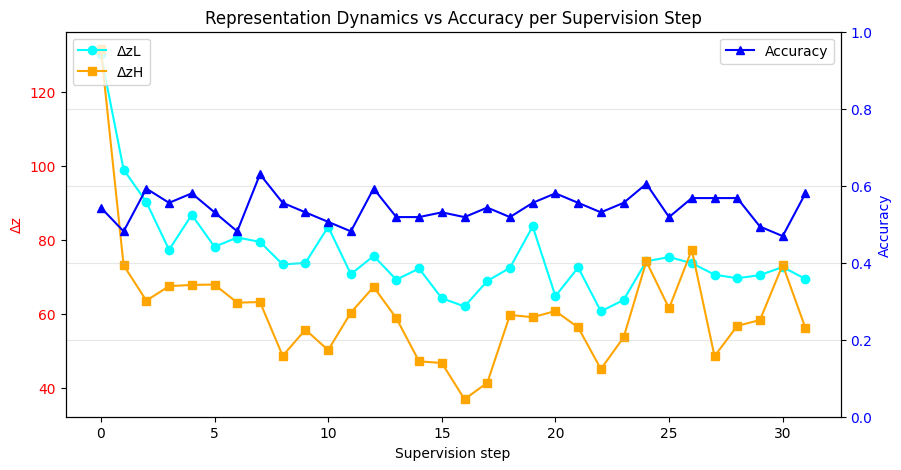

In [11]:
index = 4
correlation_dynamics_accuracy([zL_list[index]], [zH_list[index]], [accuracy[index]], L_cycles=6, H_cycles=3, N_sup=Nsup)

In [70]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

def predict(model,latent):
    out = model.model.inner.lm_head(latent.unsqueeze(0).to("cuda"))[:, model.model.config.puzzle_emb_len:].squeeze(0).cpu()
    out = torch.argmax(out,dim = 1)
    out[out==1] = 0
    out[out>1] = out[out>1]-1
    return out    


def plot_sudoku(pred, gt):
    """
    Plot a 9x9 Sudoku showing predicted numbers.
    Wrong predictions are highlighted with a red background.
    pred: predicted tensor (length 81, values 0–9)
    gt:   ground-truth tensor (length 81, values 0–9)
    """
    if not isinstance(pred, torch.Tensor) or not isinstance(gt, torch.Tensor):
        raise TypeError("Inputs must be torch.Tensors")
    if pred.numel() != 81 or gt.numel() != 81:
        raise ValueError("Both tensors must have exactly 81 elements")
    
    pred = pred.view(9, 9).cpu().numpy()
    gt = gt.view(9, 9).cpu().numpy()

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow([[0]*9]*9, cmap="gray_r")  # blank background

    for r in range(9):
        for c in range(9):
            pv = pred[r, c]
            gv = gt[r, c]

            # Check if wrong (but ignore empty predictions)
            wrong = (pv != 0 and pv != gv)

            # Red highlight for wrong cells
            if wrong:
                rect = patches.Rectangle(
                    (c - 0.5, r - 0.5), 1, 1,
                    linewidth=0, edgecolor=None,
                    facecolor="red", alpha=0.4
                )
                ax.add_patch(rect)

            # Draw number (predicted)
            if pv != 0:
                ax.text(
                    c, r, str(pv),
                    va="center", ha="center",
                    fontsize=18,
                    color="black"
                )

    # Draw grid lines
    for i in range(10):
        lw = 2 if i % 3 == 0 else 0.5
        ax.axhline(i - 0.5, color="black", linewidth=lw)
        ax.axvline(i - 0.5, color="black", linewidth=lw)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-0.5, 8.5)
    ax.set_ylim(8.5, -0.5)
    plt.tight_layout()
    plt.show()


In [71]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches


def plot_single(ax, grid, gt=None, title=""):
    """
    Draw a single 9×9 grid on a given subplot 'ax'.
    If gt is provided, wrong cells are highlighted in red.
    """
    grid = grid.view(9, 9).cpu().numpy()
    has_gt = gt is not None
    if has_gt:
        gt = gt.view(9, 9).cpu().numpy()

    ax.imshow([[0]*9]*9, cmap="gray_r")

    for r in range(9):
        for c in range(9):
            val = grid[r, c]

            # highlight wrong predictions if gt is given
            if has_gt and val != 0 and val != gt[r, c]:
                rect = patches.Rectangle(
                    (c - 0.5, r - 0.5), 1, 1,
                    linewidth=0, edgecolor=None,
                    facecolor="red", alpha=0.4
                )
                ax.add_patch(rect)

            # draw number
            if val != 0:
                ax.text(c, r, str(val),
                        va="center", ha="center",
                        fontsize=14, color="black")

    # grid lines
    for i in range(10):
        lw = 2 if i % 3 == 0 else 0.5
        ax.axhline(i - 0.5, color="black", linewidth=lw)
        ax.axvline(i - 0.5, color="black", linewidth=lw)

    ax.set_title(title, fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-0.5, 8.5)
    ax.set_ylim(8.5, -0.5)


def run_latent_predictions(model, input_grid, latent_list, groundtruth_grid):
    """
    - model: your model
    - input_grid: tensor 81 values (0–9)
    - latent_list: list of 7 latent tensors (6 zL + 1 zH)
    - groundtruth_grid: tensor 81 values (0–9)
    
    Produces a 3×3 grid of subplots:
        [input] [zL1] [zL2]
        [zL3]  [zL4] [zL5]
        [zL6]  [zH]  [ground truth]
    """

    if len(latent_list) != 7:
        raise ValueError("latent_list must contain exactly 7 elements (6×zL, 1×zH)")

    # make predictions
    preds = [predict(model, z) for z in latent_list]

    # build figure
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    # subplot order:
    # 1 input
    plot_single(axes[0, 0], input_grid, title="Input Grid")

    # 6 zL predictions
    for i in range(6):
        r = (i + 1) // 3       # row index starting from subplot 2
        c = (i + 1) % 3
        plot_single(
            axes[r, c],
            preds[i],
            gt=groundtruth_grid,
            title=f"zL {i+1}"
        )

    # zH prediction (7th)
    plot_single(
        axes[2, 1],
        preds[6],
        gt=groundtruth_grid,
        title="zH"
    )

    # ground truth
    plot_single(
        axes[2, 2],
        groundtruth_grid,
        title="Ground Truth"
    )

    plt.tight_layout()
    plt.show()


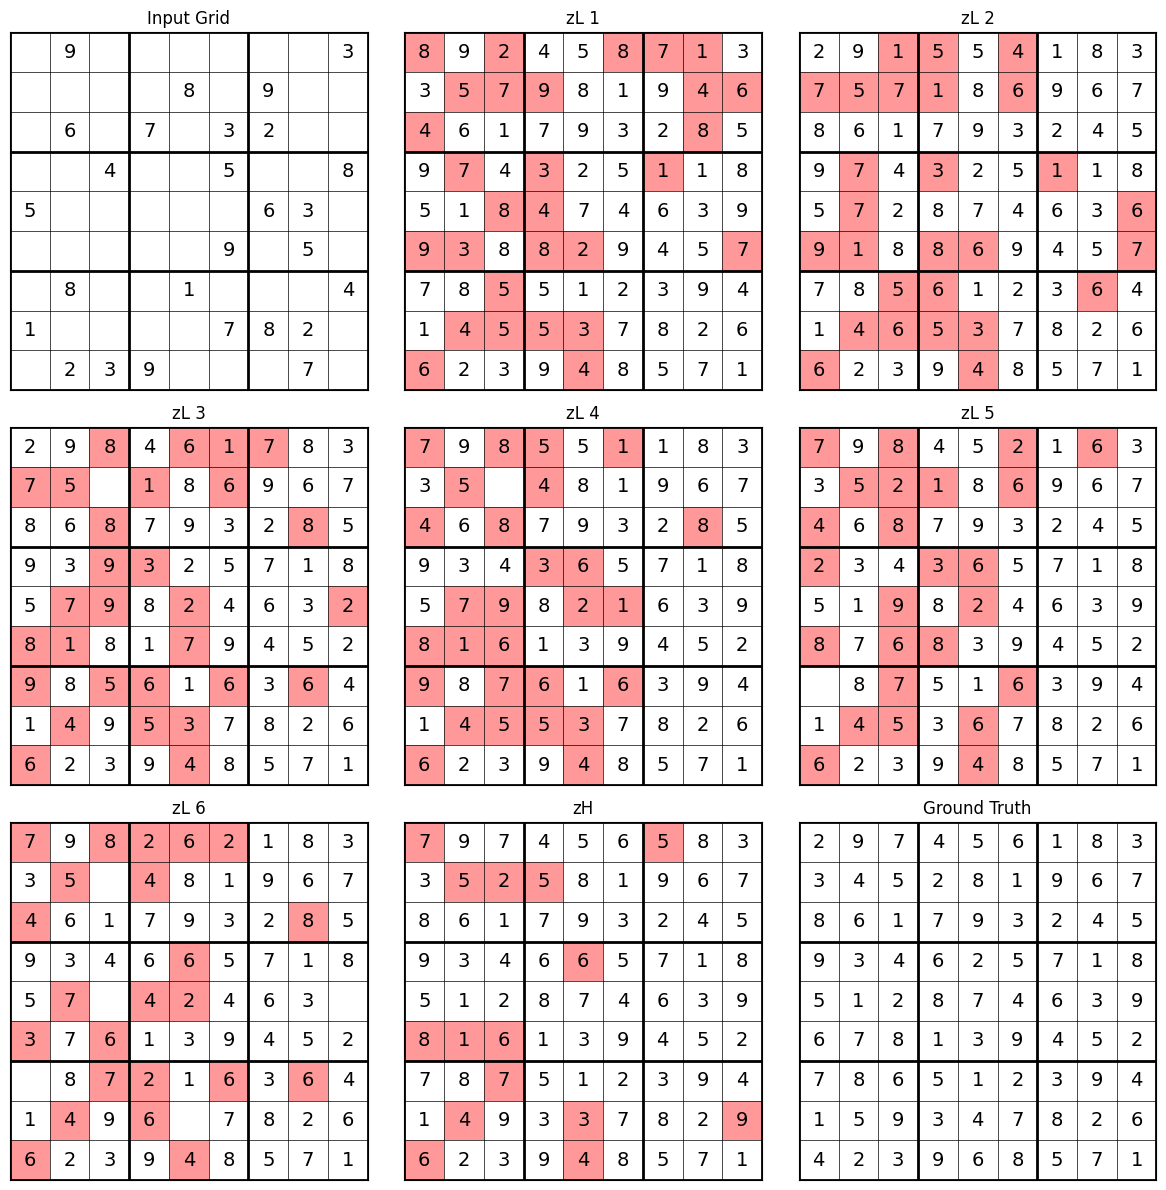

In [88]:
index = 1
cycle_index = 5
cycle_index = cycle_index*6
latent =  zL_list[index][5]
latent_list = []
for i in range(cycle_index,cycle_index+6,1):
    latent_list.append(zL_list[index][i])
latent_list.append(zH_list[index][cycle_index])
input_grid = sequences["inputs"][index]
groundtruth_grid = sequences["labels"][index]
input_grid = input_grid - 1
groundtruth_grid = groundtruth_grid - 1
run_latent_predictions(model, input_grid, latent_list, groundtruth_grid)

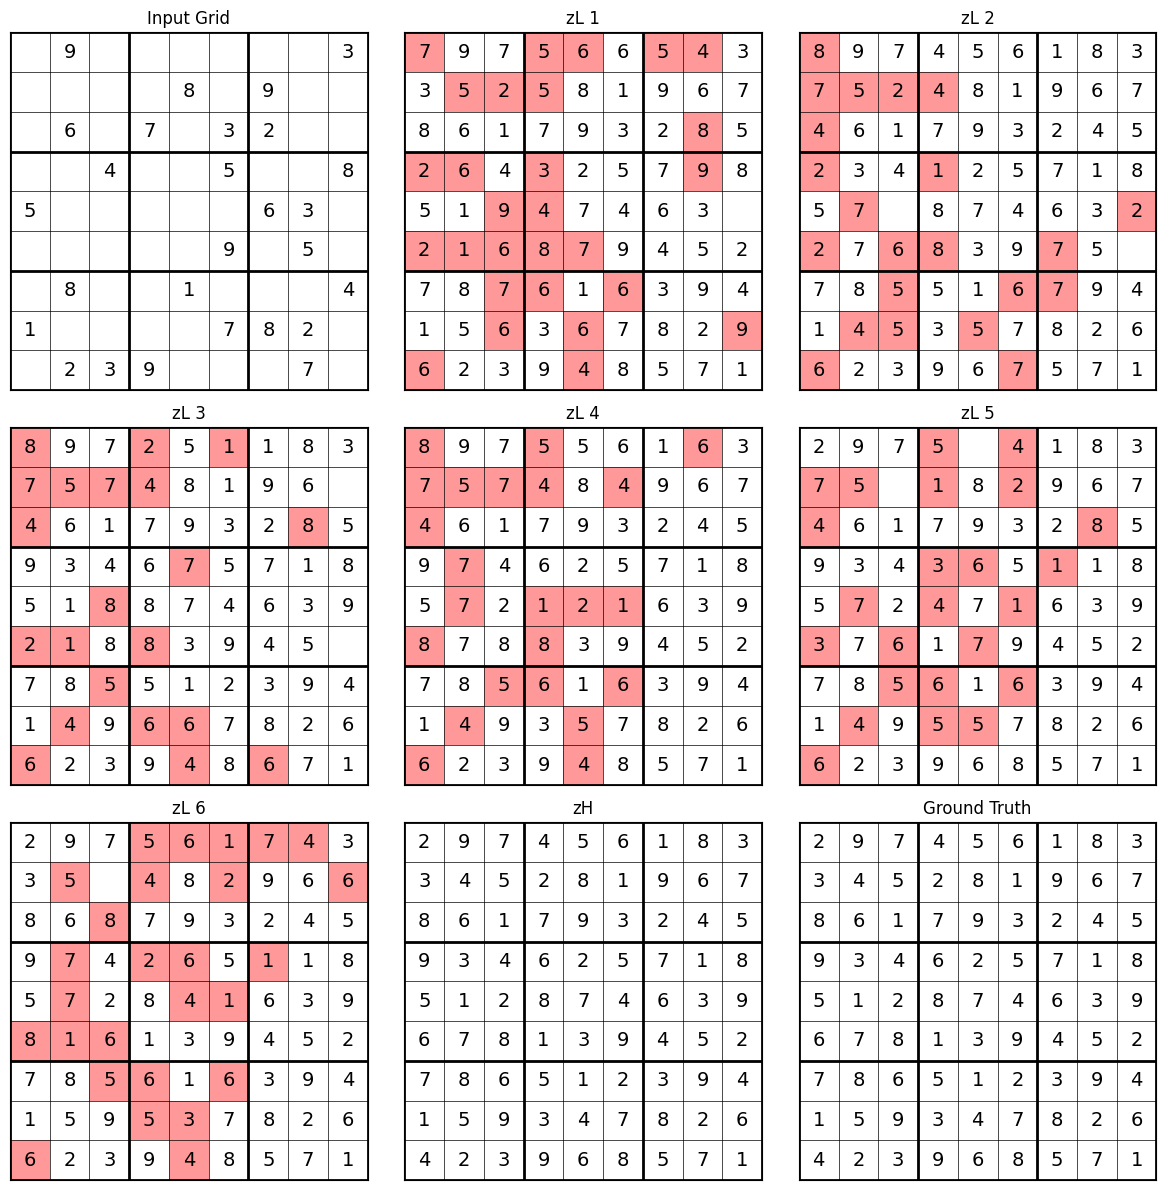

In [89]:
index = 1
cycle_index = 6
cycle_index = cycle_index*6
latent =  zL_list[index][5]
latent_list = []
for i in range(cycle_index,cycle_index+6,1):
    latent_list.append(zL_list[index][i])
latent_list.append(zH_list[index][cycle_index])
input_grid = sequences["inputs"][index]
groundtruth_grid = sequences["labels"][index]
input_grid = input_grid - 1
groundtruth_grid = groundtruth_grid - 1
run_latent_predictions(model, input_grid, latent_list, groundtruth_grid)